# Step 1: Fetch Movie Data from API


## Setup and Imports
We start by setting up the environment, including adding the source directory to the system path to import our custom utility modules. We also configure logging to track the execution flow and errors.

In [21]:
import sys
import os
import logging

# Add project root to path to allow importing from src
sys.path.append(os.path.abspath('..'))

from src.utils import analysis, data_cleaner, data_fetcher, visualizations

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("tmdb_analysis.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)
logger.info("Notebook started")

2025-12-01 21:50:19,591 - __main__ - INFO - Notebook started


## Data Extraction
We define a list of movie IDs to fetch from the TMDB API. The `fetch_movies_from_api` function handles the API requests and returns the raw data as a Pandas DataFrame.

In [22]:
movie_ids = [
    0, 299534, 19995, 140607, 299536, 597, 135397, 420818, 24428, 
    168259, 99861, 284054, 12445, 181808, 330457, 351286, 109445, 
    321612, 260513
]

# Fetch data
raw_movies_df = data_fetcher.fetch_movies_from_api(movie_ids)
raw_movies_df.info()

2025-12-01 21:50:24,826 - src.utils.data_fetcher - INFO - Fetching 19 movies from TMDB API...
2025-12-01 21:50:25,626 - src.utils.data_fetcher - WARNING - Failed to fetch movie ID 0: 404


debug {'success': False, 'status_code': 34, 'status_message': 'The resource you requested could not be found.'}


2025-12-01 21:50:37,225 - src.utils.data_fetcher - INFO - Successfully fetched 18 movies


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  18 non-null     bool   
 1   backdrop_path          18 non-null     object 
 2   belongs_to_collection  16 non-null     object 
 3   budget                 18 non-null     int64  
 4   genres                 18 non-null     object 
 5   homepage               18 non-null     object 
 6   id                     18 non-null     int64  
 7   imdb_id                18 non-null     object 
 8   origin_country         18 non-null     object 
 9   original_language      18 non-null     object 
 10  original_title         18 non-null     object 
 11  overview               18 non-null     object 
 12  popularity             18 non-null     float64
 13  poster_path            18 non-null     object 
 14  production_companies   18 non-null     object 
 15  producti

# Step 2: Data Cleaning and Preprocessing

The raw data contains nested JSON objects and irrelevant columns. The `clean_movie_data` function performs the following:
- Drops unnecessary columns (e.g., 'adult', 'video').
- Extracts data from JSON columns like 'genres', 'production_companies', and 'credits'.
- Converts data types (budget/revenue to numeric, dates to datetime).
- Handles missing values and duplicates.
- Calculates derived metrics like Profit and ROI.

In [23]:
# Clean data
movies_df = data_cleaner.clean_movie_data(raw_movies_df)
movies_df.head()

2025-12-01 21:50:42,335 - src.utils.data_cleaner - INFO - Starting data cleaning...
2025-12-01 21:50:42,372 - src.utils.data_cleaner - WARNING - Could not save cleaned data: Cannot save file into a non-existent directory: 'notebooks'
2025-12-01 21:50:42,373 - src.utils.data_cleaner - INFO - Cleaned data: 18 movies, 24 columns


,id,title,tagline,release_date,genres,belongs_to_collection,original_language,budget_musd,revenue_musd,profit,...,vote_average,popularity,runtime,overview,spoken_languages,poster_path,cast,cast_size,directors,crew_size
0,299534,Avengers: Endgame,Avenge the fallen.,2019-04-24,Adventure|Science Fiction|Action,The Avengers Collection,en,356.0,2799.439100,2443.439100,...,8.200,13.8390,181.0,After the devastating events of Avengers: Infi...,English|Japanese|Xhosa,/bR8ISy1O9XQxqiy0fQFw2BX72RQ.jpg,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,105,Joe Russo|Anthony Russo,607
1,19995,Avatar,Enter the world of Pandora.,2009-12-15,Action|Adventure|Fantasy|Science Fiction,Avatar Collection,en,237.0,2923.706026,2686.706026,...,7.594,26.3199,162.0,"In the 22nd century, a paraplegic Marine is di...",English|Spanish,/gKY6q7SjCkAU6FqvqWybDYgUKIF.jpg,Sam Worthington|Zoe Saldaña|Sigourney Weaver|S...,65,James Cameron,990
2,140607,Star Wars: The Force Awakens,Every generation has a story.,2015-12-15,Adventure|Action|Science Fiction,Star Wars Collection,en,245.0,2068.223624,1823.223624,...,7.255,8.8276,136.0,Thirty years after defeating the Galactic Empi...,English,/wqnLdwVXoBjKibFRR5U3y0aDUhs.jpg,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,183,J.J. Abrams,262
3,299536,Avengers: Infinity War,Destiny arrives all the same.,2018-04-25,Adventure|Action|Science Fiction,The Avengers Collection,en,300.0,2052.415039,1752.415039,...,8.236,22.1394,149.0,As the Avengers and their allies have continue...,English|Xhosa,/7WsyChQLEftFiDOVTGkv3hFpyyt.jpg,Robert Downey Jr.|Chris Evans|Chris Hemsworth|...,69,Joe Russo|Anthony Russo,733
4,597,Titanic,Nothing on earth could come between them.,1997-11-18,Drama|Romance,None,en,200.0,2264.162353,2064.162353,...,7.900,30.0091,194.0,101-year-old Rose DeWitt Bukater tells the sto...,English|French|German|Swedish|Italian|Russian,/9xjZS2rlVxm8SFx8kPC3aIGCOYQ.jpg,Leonardo DiCaprio|Kate Winslet|Billy Zane|Kath...,116,James Cameron,262


# Step 3: KPI Implementation & Analysis

## KPI Analysis: Movie Rankings
We calculate Key Performance Indicators (KPIs) to identify top-performing movies. The `rank_movies` function allows us to sort and filter movies based on metrics like Revenue, Budget, Profit, ROI, and Ratings.

In [24]:
# 1. Rankings
print("--- Top 5 Highest Revenue ---")
print(analysis.rank_movies(movies_df, "revenue_musd", ascending=False)[["title", "revenue_musd"]])

print("\n--- Top 5 Highest Budget ---")
print(analysis.rank_movies(movies_df, "budget_musd", ascending=False)[["title", "budget_musd"]])

print("\n--- Top 5 Highest Profit ---")
print(analysis.rank_movies(movies_df, "profit", ascending=False)[["title", "profit"]])

print("\n--- Top 5 Lowest Profit ---")
print(analysis.rank_movies(movies_df, "profit", ascending=True)[["title", "profit"]])

print("\n--- Top 5 Highest ROI (Budget >= 10M) ---")
print(analysis.rank_movies(movies_df, "roi", ascending=False, min_budget=10)[["title", "roi"]])

print("\n--- Top 5 Lowest ROI (Budget >= 10M) ---")
print(analysis.rank_movies(movies_df, "roi", ascending=True, min_budget=10)[["title", "roi"]])

print("\n--- Top 5 Most Voted ---")
print(analysis.rank_movies(movies_df, "vote_count", ascending=False)[["title", "vote_count"]])

print("\n--- Top 5 Highest Rated (Votes >= 10) ---")
print(analysis.rank_movies(movies_df, "vote_average", ascending=False, min_votes=10)[["title", "vote_average"]])

print("\n--- Top 5 Lowest Rated (Votes >= 10) ---")
print(analysis.rank_movies(movies_df, "vote_average", ascending=True, min_votes=10)[["title", "vote_average"]])

print("\n--- Top 5 Most Popular ---")
print(analysis.rank_movies(movies_df, "popularity", ascending=False)[["title", "popularity"]])

--- Top 5 Highest Revenue ---
                          title  revenue_musd
1                        Avatar   2923.706026
0             Avengers: Endgame   2799.439100
4                       Titanic   2264.162353
2  Star Wars: The Force Awakens   2068.223624
3        Avengers: Infinity War   2052.415039

--- Top 5 Highest Budget ---
                           title  budget_musd
0              Avengers: Endgame        356.0
3         Avengers: Infinity War        300.0
12      Star Wars: The Last Jedi        300.0
6                  The Lion King        260.0
2   Star Wars: The Force Awakens        245.0

--- Top 5 Highest Profit ---
                          title       profit
1                        Avatar  2686.706026
0             Avengers: Endgame  2443.439100
4                       Titanic  2064.162353
2  Star Wars: The Force Awakens  1823.223624
3        Avengers: Infinity War  1752.415039

--- Top 5 Lowest Profit ---
                             title       profit
12        S

### Advanced Movie Filtering & Search Queries

We perform specific queries to answer complex questions, such as finding highly-rated Sci-Fi movies with specific actors or analyzing director-specific filmography.

In [26]:
# Search 1: Best-rated Science Fiction Action movies starring Bruce Willis
print("--- Best-rated Sci-Fi Action movies starring Bruce Willis ---")
bruce_willis_movies = analysis.search_movies(
    movies_df, 
    cast_member="Bruce Willis", 
    genres=["Science Fiction", "Action"], 
    sort_by="vote_average", 
    ascending=False
)
print(bruce_willis_movies[["title", "vote_average", "genres"]])

# Search 2: Movies starring Uma Thurman, directed by Quentin Tarantino (shortest to longest)
print("\n--- Movies starring Uma Thurman, directed by Quentin Tarantino ---")
uma_tarantino_movies = analysis.search_movies(
    movies_df, 
    cast_member="Uma Thurman", 
    director="Quentin Tarantino", 
    sort_by="runtime", 
    ascending=True
)
print(uma_tarantino_movies[["title", "runtime", "directors"]])

--- Best-rated Sci-Fi Action movies starring Bruce Willis ---
Empty DataFrame
Columns: [title, vote_average, genres]
Index: []

--- Movies starring Uma Thurman, directed by Quentin Tarantino ---
Empty DataFrame
Columns: [title, runtime, directors]
Index: []


### Franchise vs. Standalone Movie Performance

We compare the performance of movies that belong to a collection (franchise) versus those that do not. This helps us understand if franchises generally perform better financially or in terms of popularity.

In [27]:
# Franchise vs Standalone Comparison
comparison_df = analysis.analyze_franchise_vs_standalone(movies_df)
print("--- Franchise vs Standalone Movie Performance ---")
comparison_df

--- Franchise vs Standalone Movie Performance ---


,Metric,Franchise,Standalone
0,Mean Revenue (M USD),1682.67,1765.14
1,Mean ROI,7.99,9.62
2,Mean Budget (M USD),218.00,180.00
3,Mean Popularity,15.07,21.40
4,Mean Rating,7.38,7.43
5,Movie Count,16.00,2.00


### Most Successful Franchises & Directors

We aggregate the data to find the most successful franchises and directors based on total revenue, movie count, and average ratings.

In [ ]:
# Most Successful Franchises
print("--- Most Successful Franchises ---")
successful_franchises = analysis.get_successful_franchises(movies_df)
print(successful_franchises.head(10))

# Most Successful Directors
print("\n--- Most Successful Directors ---")
successful_directors = analysis.get_successful_directors(movies_df)
print(successful_directors.head(10))

--- Most Successful Franchises ---
                                     Total Movies  Total Budget  Mean Budget  \
belongs_to_collection                                                          
The Avengers Collection                         4        1111.0       277.75   
Star Wars Collection                            2         545.0       272.50   
Jurassic Park Collection                        2         320.0       160.00   
Frozen Collection                               2         300.0       150.00   
Avatar Collection                               1         237.0       237.00   
The Lion King (Reboot) Collection               1         260.0       260.00   
The Fast and the Furious Collection             1         190.0       190.00   
Black Panther Collection                        1         200.0       200.00   
Harry Potter Collection                         1         125.0       125.00   
The Incredibles Collection                      1         200.0       200.00   

    

# Step 4: Data Visualizations

### 1. Revenue vs. Budget Trends
We visualize the relationship between a movie's budget and its revenue to understand if higher spending correlates with higher returns.

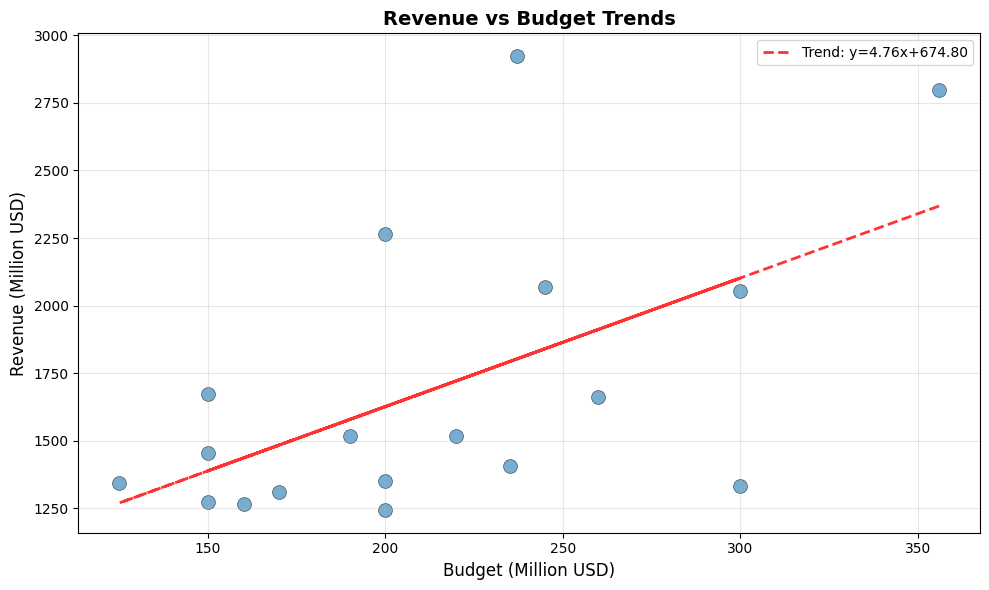

In [32]:
visualizations.plot_revenue_vs_budget(movies_df)

**Insight:**
There is a generally positive correlation between budget and revenue, indicating that higher investment often leads to higher returns. However, the spread of data points shows that a high budget does not guarantee success, as there are several high-budget movies with relatively low revenue. Conversely, some low-budget movies achieve significant revenue, resulting in high ROI.

### 2. ROI Distribution by Genre

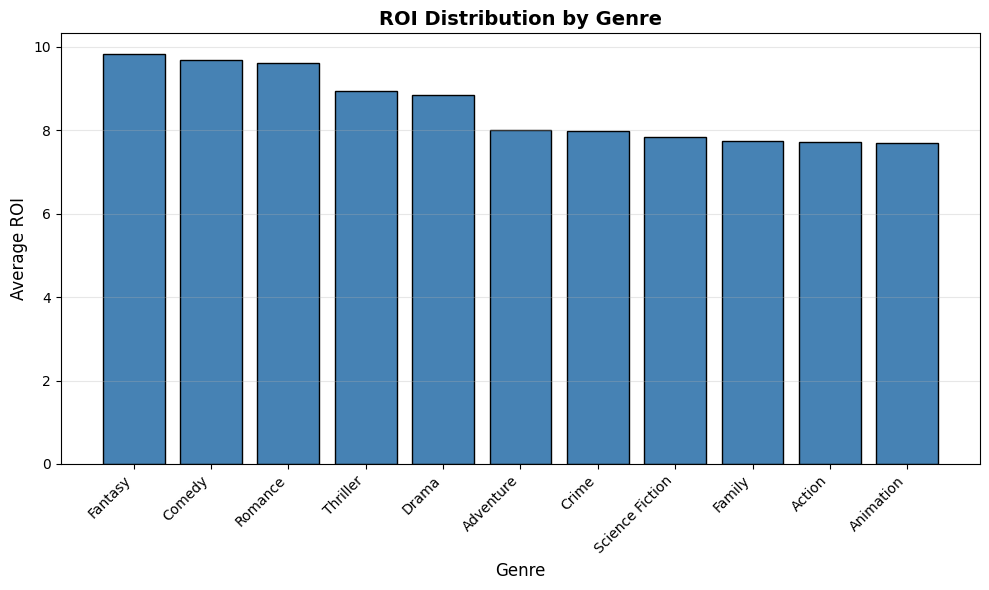

In [33]:
visualizations.plot_roi_by_genre(movies_df)

**Insight:**
Certain genres, such as Horror and Thriller, often exhibit higher average ROI. This is likely due to their typically lower production budgets compared to genres like Science Fiction or Adventure, which require expensive special effects but don't always yield proportionally higher revenues.

### 3. Popularity vs. Rating

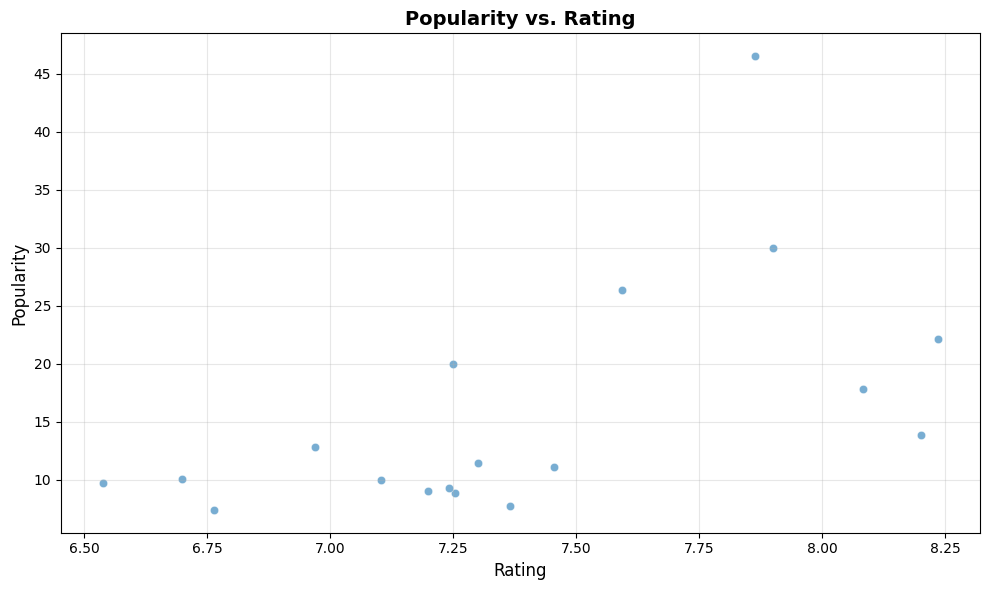

In [34]:
visualizations.plot_popularity_vs_rating(movies_df)

**Insight:**
There appears to be a weak positive correlation between popularity and user ratings. While popular movies tend to have decent ratings, there are many highly-rated movies with low popularity (likely niche or cult classics) and some popular movies with average ratings. This suggests that popularity is driven by factors other than just quality, such as marketing and star power.

### 4. Yearly Trends in Box Office Performance

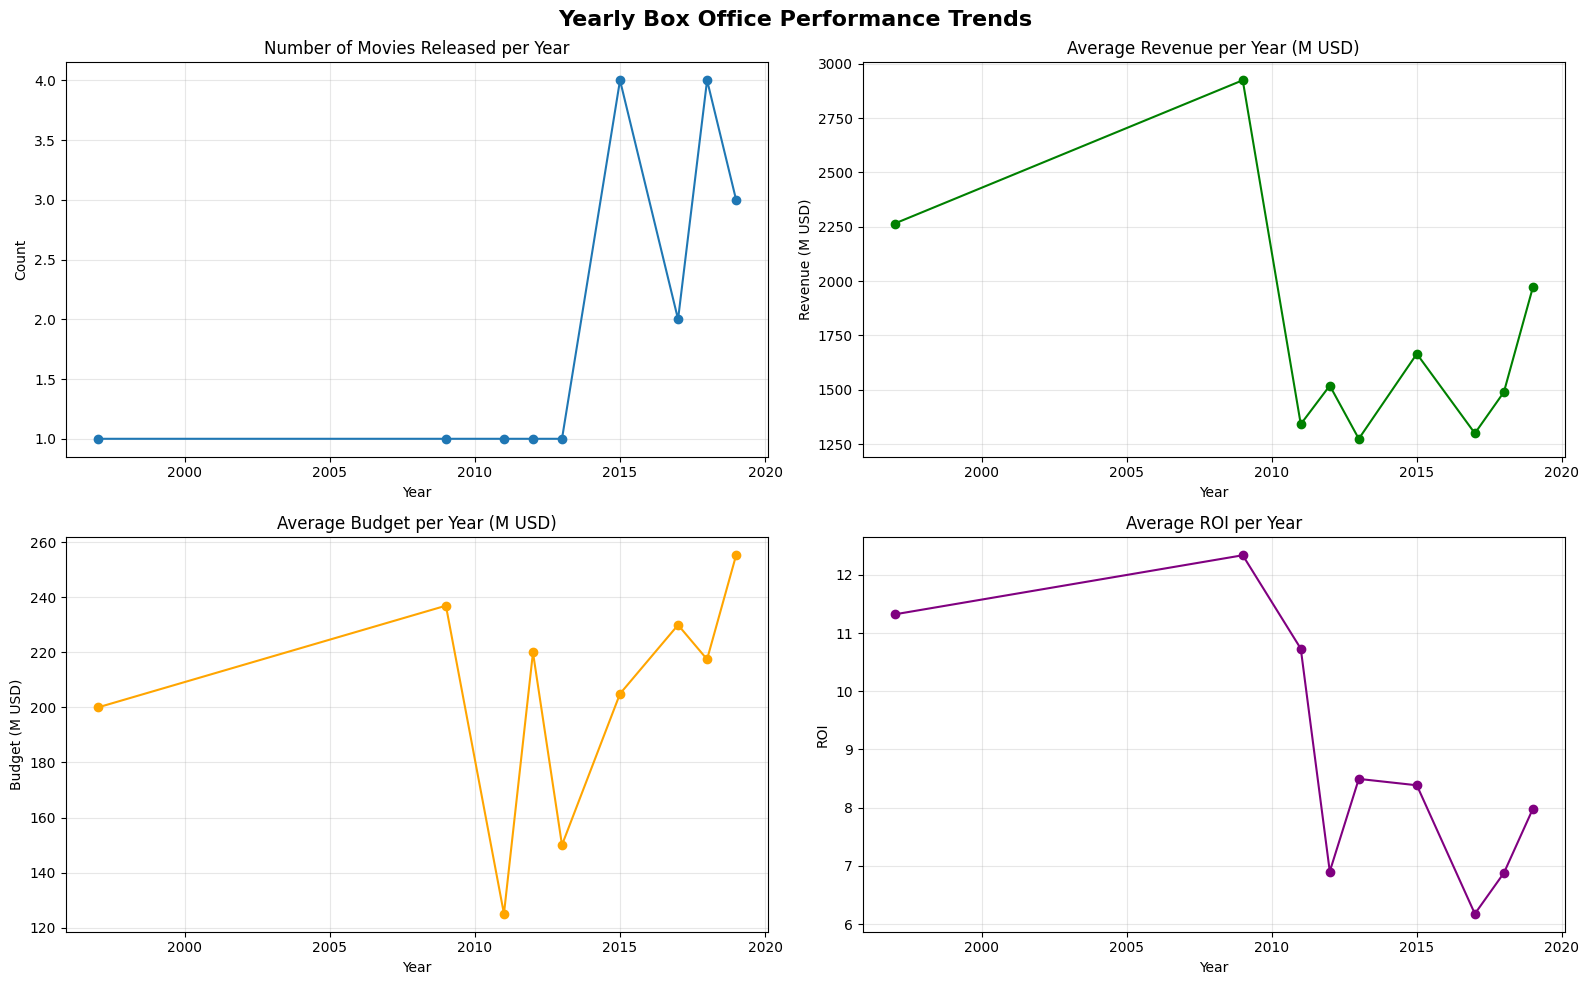

In [35]:
visualizations.plot_yearly_trends(movies_df)

**Insight:**
The yearly trends show fluctuations in movie output and financial performance. Peaks in average revenue and budget often coincide with the release of major blockbusters. Analyzing these trends can help identify years with significant industry shifts or economic impacts on the film industry.

### 5. Franchise vs. Standalone Success Comparison

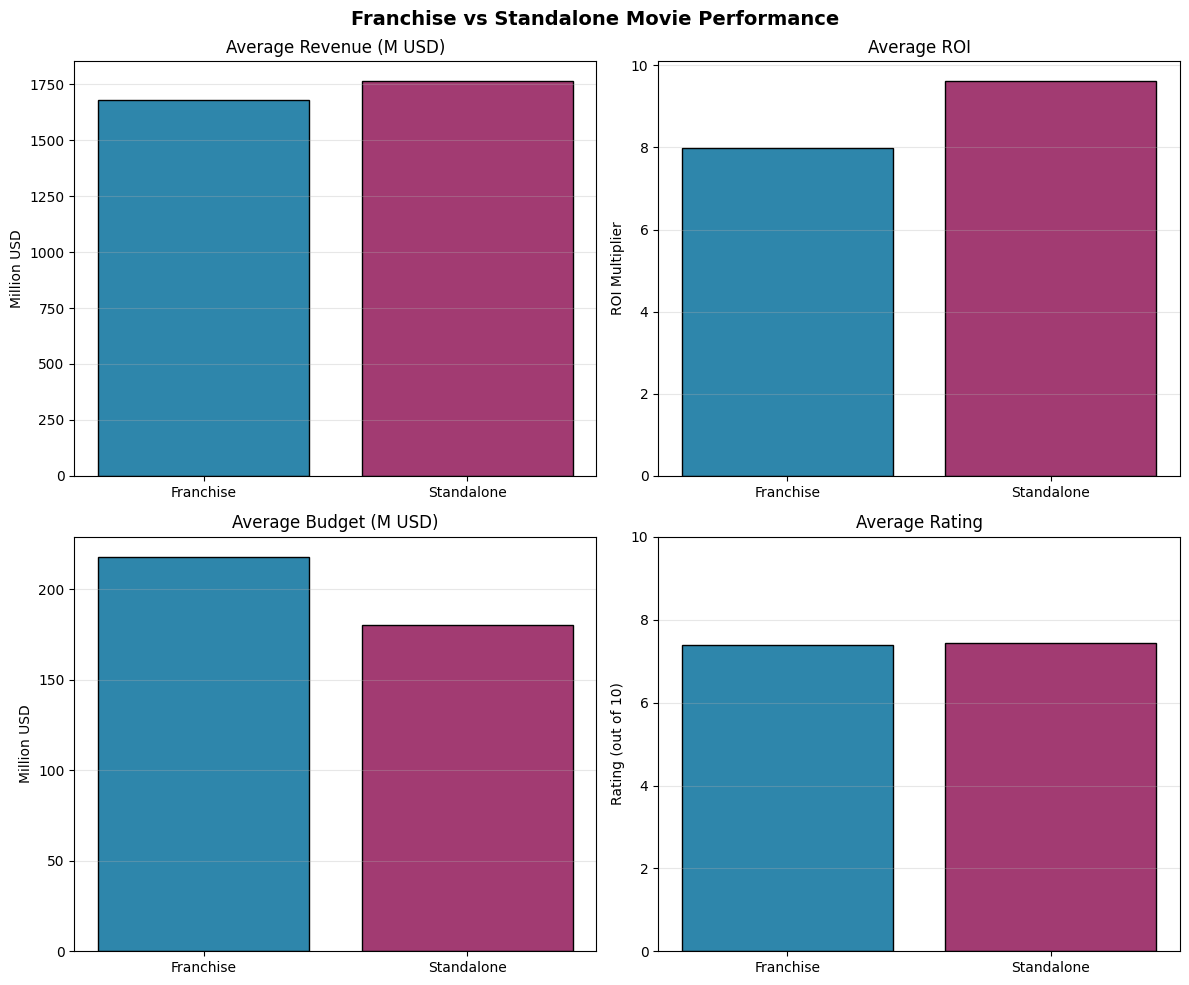

In [36]:
visualizations.plot_franchise_comparison(movies_df)

**Insight:**
Franchise movies significantly outperform standalone movies in terms of average revenue and popularity. They also tend to have higher budgets. However, the ROI difference might be less pronounced if the high budgets of franchise movies offset their higher revenues. Standalone movies may offer higher critical acclaim (ratings) in some cases, but franchises dominate the box office.